# AnimeGM - Autoencoder - Keras
GOAL: Generate new anime-style images

View model: `$ tensorboard --logdir=autoencoder`

Methodology:
1. Build a dataset of images suitable for out needs
2. Build a generative model.
3. Train the model
4. Generate a new image with random numbers
5. Transfer style to a photo
6. Examine results

It seems that this is our best model yet. A few notes:
- the larger the resized image, the better.
- more data is good
- about 100 epochs is good but we can use more.
- best so far is using a batch size of 100
- a lost of 0.37 is the best we can do.

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import color
import seaborn as sns; sns.set()
from os import listdir
from os.path import join
from skimage import data
import tensorflow as tf
import keras
from keras import backend as K
from keras.layers import Conv2D, Dense, Flatten, Input, MaxPooling2D, Reshape, UpSampling2D
from keras.models import Model
from keras.optimizers import SGD
from keras.callbacks import TensorBoard
%matplotlib inline

Using TensorFlow backend.


### Functions

In [2]:
# tf image preprocessing
# load, decoded and resize
def parse_image(flatten, n_channels, path, resize_dim):
    """parses an image and converts it to the type we want.
    flatten: to flatten the image into a vector or not.
    n_channels: number of color channels to set (color / grayscale) - 1 or 3.
    path: path to the image.
    resize_dim: the number of pixels the image should be per size.
    
    return: the image as a vector or matrix
    """
    
    image_string = tf.read_file(path)
    
    # decode
    image = tf.image.decode_jpeg(image_string, channels=3)
    
    # check for 1 channel
    # if so, grayscale
    if (n_channels == 1):
        image = tf.image.rgb_to_grayscale(image)
        
    # resize the image
    image = tf.image.resize_images(image, [resize_dim, resize_dim])
    
    # feature normalize the image
    image = tf.divide(image, 255)
    
    # check if we want the image flattened
    # if so, flatten the image
    if flatten == True:
        image = tf.reshape(image, [-1])
    
    return image

In [3]:
def data_generator(paths, iter, mode, sess):   
    """Creates a data generator.
    paths: image paths to feed the generator with.
    iter: TF dataset iterator.
    mode: the mode we want (train or test).
    sess: instance of a TF session.
    
    return: an image batch
    """
    
    next_batch = iter.get_next()
    
    # Initialize an iterator over a dataset.
    sess.run(iter.initializer, feed_dict={image_paths: paths})

    # yield the next batch
    while 1:
        batch = sess.run(next_batch)
        
        # check for mode
        if mode == 'train':
            result = batch, batch
        elif mode == 'test':
            result = batch
            
        yield result

In [4]:
def show_image(image, n_channels, resize_dim):
    """Shows an image.
    image: image data to show.
    n_channels: number of color channels to set (color / grayscale) - 1 or 3.
    resize_dim: the number of pixels the image should be per size.
    """
    
    # check for 1 channel
    # if so, grayscale
    if (n_channels == 1):
        image = image.reshape((resize_dim, resize_dim))
    else:
        image = image.reshape((resize_dim, resize_dim, n_channels))

    plt.imshow(image, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [5]:
def show_images(images, n_channels, resize_dim):
    """Shows a set of images.
    images: a set of image data to show.
    n_channels: number of color channels to set (color / grayscale) - 1 or 3.
    resize_dim: the number of pixels the image should be per size.
    """
    
   # get the number of images
    n_images = images.shape[0]
    
    if n_images == 1:
        show_image(images[0], n_channels, resize_dim)
        return
    
    # get the square root of the number of images
    squareroot = int(np.ceil(np.sqrt(n_images)))
    
    # size of the figure
    figsize = (10, 10)
    
    # configure subplots
    fig, ax = plt.subplots(squareroot, squareroot, figsize=figsize,
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)

    for i, axi in enumerate(ax.flat):
        # exit if the index of subplots is greater than amount of images
        if i > n_images - 1:
            return
        
        image = images[i]
        
        # check for 1 channel
        # if so, grayscale
        if (n_channels == 1):
            image = image.reshape((resize_dim, resize_dim))
        else:
            image = image.reshape((resize_dim, resize_dim, n_channels))

        im = axi.imshow(image, cmap='gray')

### Variables

In [6]:
# data dir
dir_name = 'danbooru-small'

# log dir
log_dir = '/Users/Admin/data-science/animeGM/log'

In [7]:
# number of training or test examples
n_train = 100
n_test = 10

In [8]:
# data manipulation
resize_dim = 64
n_channels = 1
n_features = resize_dim * resize_dim * n_channels

# model 
flatten = False

In [9]:
# hyper parameters~~~~
batch_size = 100
n_batches = int(n_train / batch_size)
n_epochs = 10

cnn_dim = int(resize_dim / 2 / 2 / 2)

## 1. Build a dataset
Pull in an existing dataset and modify it for my needs.

Lets start with the danbooru 2017 anime image dataset. Now this dataset is huge. So we are only going to use 1 torrent of the SFW subset.

### Prepare data

In [10]:
# get filenames and join paths as np array
base_filenames = listdir(dir_name)
filename_paths = [join(dir_name, base_filename) for base_filename in base_filenames]
filename_paths = np.array(filename_paths)

In [11]:
# create paths for train and test
train_paths = filename_paths[:-n_test][:n_train]
test_paths = filename_paths[:n_test]

### Create dataset

In [12]:
# create a placeholder for image_paths
image_paths = tf.placeholder(tf.string, shape=[None])

# create a dataset from the paths
dataset = tf.data.Dataset.from_tensor_slices(image_paths)
dataset = dataset.map(lambda image_paths: parse_image(flatten, n_channels, image_paths, resize_dim))
dataset = dataset.shuffle(buffer_size=n_train)
dataset = dataset.batch(batch_size)
dataset = dataset.repeat()

# iterators
iter = dataset.make_initializable_iterator()

## 2. Build a generative model
Lets build an autoencoder

In [13]:
# input placeholder
inputs = Input(shape=(resize_dim, resize_dim, n_channels))

# encoded the input with convolutions and pooling
x = Conv2D(16, (3, 3), activation='relu', name='encoder_0', padding='same')(inputs)
# x = Conv2D(16, (3, 3), activation='relu', name='encoder_1', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same', name='pool_0')(x)
x = Conv2D(8, (3, 3), activation='relu', name='encoder_2', padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', name='encoder_3', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same', name='pool_1')(x)
x = Conv2D(8, (3, 3), activation='relu', name='encoder_4', padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', name='encoder_5', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same', name='pool_2')(x)

# flatten and run through a dnn
x = Flatten()(encoded)
x = Dense(128, activation='relu', name='cnn_0')(x)
# x = Dense(128, activation='relu', name='cnn_1')(x)
x = Dense(64, activation='relu', name='cnn_2')(x)
# x = Dense(64, activation='relu', name='cnn_3')(x)
x = Dense(cnn_dim * cnn_dim * n_channels, activation='relu', name='cnn_4')(x)
dnn = Reshape((cnn_dim, cnn_dim, n_channels))(x)

# decoded the compression and upsampling
x = Conv2D(8, (3, 3), activation='relu', name='decoder_0', padding='same')(dnn)
x = Conv2D(8, (3, 3), activation='relu', name='decoder_1', padding='same')(x)
x = UpSampling2D((2, 2), name='upsample_0')(x)
x = Conv2D(8, (3, 3), activation='relu', name='decoder_2', padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', name='decoder_3', padding='same')(x)
x = UpSampling2D((2, 2), name='upsample_1')(x)
x = Conv2D(16, (3, 3), activation='relu', name='decoder_4', padding='same')(x)
# x = Conv2D(16, (3, 3), activation='relu', name='decoder_5', padding='same')(x)
x = UpSampling2D((2, 2), name='upsample_2')(x)
decoded = Conv2D(n_channels, (3, 3), activation='sigmoid', name='decoder_6', padding='same')(x)

### Compile the model with cost and optimizer

In [14]:
# this model maps inputs to its reconstructions
autoencoder = Model(inputs, decoded)

In [15]:
autoencoder.compile(loss='binary_crossentropy', 
              optimizer='adadelta')

## 3. Train the model

In [16]:
# create a session to use the graph
sess = tf.Session()

# create an instance of the generator
training_batch_generator = data_generator(train_paths, iter, 'train', sess)
    
# train
autoencoder.fit_generator(training_batch_generator, 
                          steps_per_epoch=n_batches,
                          epochs=n_epochs,
                          callbacks=[TensorBoard(log_dir=log_dir)])

Epoch 1/10
1/1 [==============================] - 5s 5s/step - loss: 0.6932
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 0.6930
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.6928
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 0.6926
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.6924
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.6921
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.6919
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: 0.6916
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 0.6912
Epoch 10/10
1/1 [==============================] - 2s 2s/step - loss: 0.6908


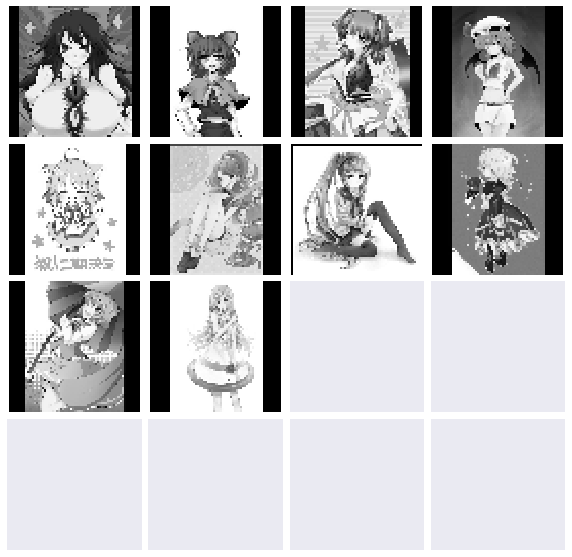

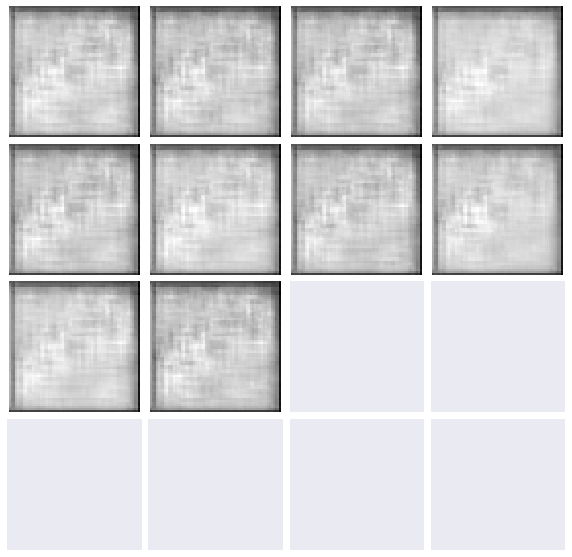

In [17]:
# create an instance of the generator
test_batch_generator = data_generator(test_paths, iter, 'test', sess)
    
# get batch
test_batch = next(test_batch_generator)

# show the test images
show_images(test_batch, n_channels, resize_dim)

# create reconstructions
reconstructions = autoencoder.predict(test_batch)

# show the reconstructioned test images
show_images(reconstructions, n_channels, resize_dim)

## Results
### Test 1
image_size =  32 x 32  
n_channels = 1  
n_epochs = 100  
batch_size = 100  
lost = 0.37  
NOTE: too pixalated and noisy

### Test 2
image_size =  64 x 64  
n_channels = 1  
n_epochs = 40  
batch_size = 100  
lost = 0.3654  
NOTE: The larger image size helps use get closer to the actual images. They are still blurry

### Test 3
n_conv_layers = 4
image_size =  64 x 64  
n_channels = 3  
n_epochs = 70  
batch_size = 100  
lost = 0.5266  
NOTE: bad

### Test 4
n_conv_layers = 4
image_size =  64 x 64  
n_channels = 3  
n_epochs = 50  
batch_size = 100  
lost = 0.6194
NOTE: bad

### Test 5
n_conv_layers = 4
image_size =  64 x 64  
n_channels = 1  
n_epochs = 50  
batch_size = 100  
lost = 0.6732
NOTE: bad

### Test 6
n_conv_layers = 3
dnn_layers = 2
image_size =  64 x 64  
n_channels = 1  
n_epochs = 50  
batch_size = 10  
lost = 0.4491
NOTE: interesting..

### Test 7
n_conv_layers = 3
dnn_layers = 2
image_size =  64 x 64  
n_channels = 1  
n_epochs = 50  
batch_size = 100  
lost = 0.7030
NOTE: getting some details.

### Test 8
n_conv_layers = 3
dnn_layers = 5
image_size =  64 x 64  
n_channels = 1  
n_epochs = 100  
batch_size = 100  
lost = 0.6330
NOTE: totally washed out.

### Test 9
n_conv_layers = 6
dnn_layers = 5
image_size =  64 x 64  
n_channels = 1  
n_epochs = 50  
batch_size = 100  
lost = 0.6774
NOTE: totally washed out.